In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np

# Import scaffoldgraph
import scaffoldgraph as sg

# Import networkx
import networkx as nx

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# Import rdkit
from rdkit.Chem import Draw
from rdkit import Chem

import random
import os

# Load data

In [2]:
data = pd.read_csv('/home/marcossantana/Downloads/generated_mols_properties.csv')
actives = data[data['probas']>=0.25]
actives.reset_index(drop=True,inplace=True)
print(data.shape,actives.shape)

(230100, 14) (119, 14)


In [3]:
actives.head()

,Smiles,probas,preds,Id,timestamp,SAScore,MW,logP,HAC,HBA,HBD,ROTB,Num_rings,TPSA
0,CC(C)[C@H](NC(=O)c1[nH]cnc1C(=O)N[C@@H](Cc1ccc...,0.303419,1,mol-914-28/05/2021-01:43:48,28/05/2021-01:43:48,3.570512,611.740,3.18120,44,8,3,12,3,159.79
1,Cc1ccccc1NC(=O)CC[C@@H]1CC[C@@H](C(=O)N[C@@H](...,0.300552,1,mol-1430-28/05/2021-01:43:48,28/05/2021-01:43:48,3.382083,431.493,-0.15588,31,5,5,10,2,173.48
2,Cc1ccc(C2C(C(=O)c3ccc(C)o3)=C(O)C(=O)N2c2ccc(C...,0.326266,1,mol-4372-28/05/2021-01:43:48,28/05/2021-01:43:48,2.726794,417.417,4.37754,31,5,2,5,4,108.05
3,COc1ccc(N(C(=O)Cn2nnc3ccccc32)C(C(=O)NC2CCCC2)...,0.429053,1,mol-6310-28/05/2021-01:43:48,28/05/2021-01:43:48,2.877563,499.571,3.97880,37,7,2,8,5,109.58
4,Cc1ccc(CN2CCNC(=O)C2=O)cc1,0.497304,1,mol-6555-28/05/2021-01:43:48,28/05/2021-01:43:48,2.072438,218.256,0.45342,16,2,1,2,2,49.41


In [4]:
columns = actives.columns[1:].tolist()

# Network

In [5]:
network = sg.ScaffoldNetwork.from_dataframe(df=actives, smiles_column='Smiles',name_column='Id',data_columns=columns,progress=True)

In [6]:
print(sg.utils.summary(network))

Type: ScaffoldNetwork
Number of molecule nodes: 118
Number of scaffold nodes: 550
Number of edges: 1383
Max hierarchy: 6
Min hierarchy: 1



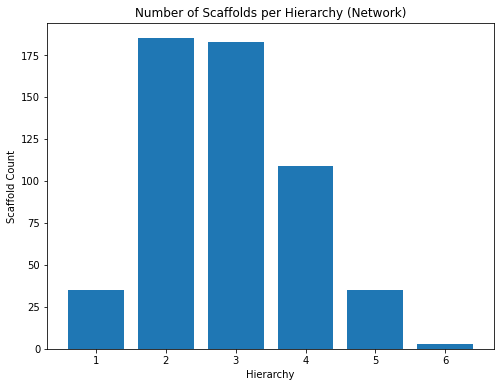

In [7]:
# We can get the number of scaffolds in each hierarchy easily

counts = network.get_hierarchy_sizes()  # returns a collections Counter object
#lists = sorted()
x, y = zip(*counts.items())

# Plot sizes as bar chart

plt.figure(figsize=(8, 6))
plt.bar(x, y)
plt.xlabel('Hierarchy')
plt.ylabel('Scaffold Count')
plt.title('Number of Scaffolds per Hierarchy (Network)')
plt.show()

In [8]:
network.min_hierarchy(),network.max_hierarchy()

(1, 6)

In [9]:
hier6 = list(network.get_scaffolds_in_hierarchy(6))
hier5 = list(network.get_scaffolds_in_hierarchy(5))
hier4 = list(network.get_scaffolds_in_hierarchy(4))
hier3 = list(network.get_scaffolds_in_hierarchy(3))
hier2 = list(network.get_scaffolds_in_hierarchy(2))
hier1 = list(network.get_scaffolds_in_hierarchy(1))

/home/marcossantana/anaconda3/lib/python3.7/site-packages/rdkit/Chem/Draw/IPythonConsole.py:192: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


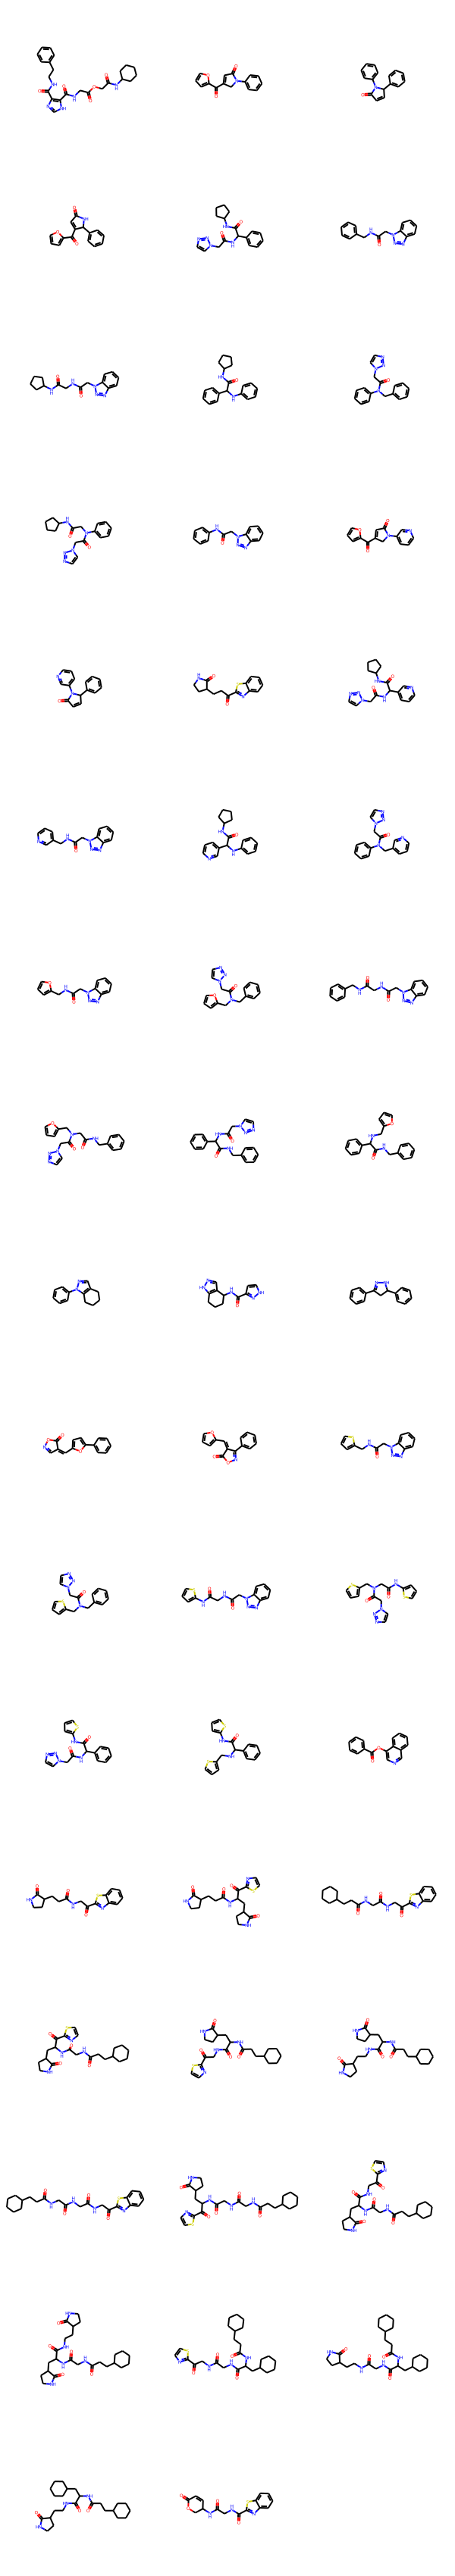

In [10]:
Draw.MolsToGridImage(list(map(Chem.MolFromSmiles,hier3)))

# Visualization

In [11]:
# Import the visualization utility.
from scaffoldgraph.vis.notebook import cytoscape

In [12]:
visualizer = cytoscape.CytoscapeVisualizer(network)  # initialize.

In [13]:

from scaffoldgraph.vis import color_scaffold_nodes_by_attribute
from rdkit.Chem.Draw import rdMolDraw2D
from ipywidgets import interact, fixed
import ipywidgets as widgets

def draw(visualizer, molecule_id, layout):
    layout_kwargs = {'name': layout}
    widget = visualizer.draw_for_molecule(molecule_id, layout_kwargs)

    widget.layout.height = '600px'
    return widget
    

# Get the list of all molecules in the graph and sort.
mol_ids = sorted(list(network.get_molecule_nodes()))

# List of a subset of available layouts in cytoscape.
layouts = ['dagre', 'breadthfirst', 'cose']


# Add a 'background-color' attribute to each scaffold node.
# The cmap can either be a string or a matplotlib.cm.Colormap object.
color_scaffold_nodes_by_attribute(network, 'hierarchy', cmap='BuPu', label='color')

# Create a style element for the visualizer.
background_style = {
    "selector": "node[color]",   # select nodes with an attribute 'color'
    "style": {
        "background-color": "data(color)",  # set background-color from attribute.
    }
}

# We can also customize rdkit drawing options (need a transparent background).
drawOpts = rdMolDraw2D.MolDrawOptions()
drawOpts.clearBackground = False
drawOpts.bondLineWidth = 4

widgets.IntSlider(
value=7,
min=0,
max=10,
step=1,
description='Test:',
disabled=False,
continuous_update=False,
orientation='horizontal',
readout=True,
readout_format='d'
)
# Now create the visualization.
interact(
    draw,
    visualizer=fixed(visualizer),
    molecule_id=actives.Id.tolist(),
    layout=layouts
);

# # Create a new visualizer with new options.
# vis = cytoscape.CytoscapeVisualizer(
#     tree,
#     refresh_images=True,
#     rd_draw_options=drawOpts,
# )

# # Append the style element to the visualizer.
# vis.style.append(background_style)

# # Create visualization.
# widget = vis.draw_for_scaffold('c1ccncc1')
# widget.layout.height = '600px'
# widget

interactive(children=(Dropdown(description='molecule_id', options=('mol-914-28/05/2021-01:43:48', 'mol-1430-28…

In [14]:
molecules_hier3 = set(x for s,_ in enumerate(hier3) for x in network.get_molecules_for_scaffold(hier3[s]))

In [15]:
molssmi_hier3 = actives[actives['Id'].isin(molecules_hier3)]

In [16]:
len(set(hier3)),len(hier3)

(183, 183)

In [17]:
len(molssmi_hier3)

99

# Chemical space

In [18]:
from rdkit.Chem import AllChem
import umap
import hdbscan
from sklearn.decomposition import PCA
import matplotlib as mpl
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [19]:
sns.set_context(font_scale=1.5, context='paper',rc={'figure.figsize': (12, 8)})

In [20]:
def getFP(mol,bits=1024,radius=2):
    if not isinstance(mol, Chem.rdchem.Mol):
        mol = Chem.MolFromSmiles(mol)
    return np.asarray(AllChem.GetMorganFingerprintAsBitVect(mol, nBits=bits, radius=radius)).reshape(-1,bits)

In [21]:
active_mols_fp = np.concatenate(list(map(getFP, molssmi_hier3.Smiles.tolist())))

active_scaffolds_fp = np.concatenate(list(map(getFP, hier3)))

In [22]:
active_scaffolds_fp.shape,active_mols_fp.shape

((183, 1024), (99, 1024))

In [23]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.0, metric='euclidean',n_components=2)

In [24]:
embeddings_scaffolds = reducer.fit_transform(active_scaffolds_fp)
embeddings_mols = reducer.fit_transform(active_mols_fp)

/home/marcossantana/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


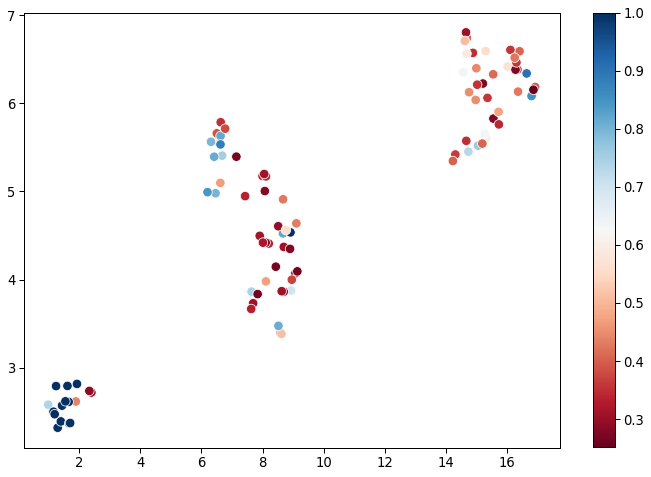

In [25]:
fig,ax = plt.subplots(1,figsize=(12,8))
sns.scatterplot(*embeddings_mols.T,hue=molssmi_hier3.probas,s=90,ax=ax, palette='RdBu')

norm = plt.Normalize(molssmi_hier3['probas'].min(), molssmi_hier3['probas'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)


## Kmeans

Clustering using [Kmeans](https://scikit-learn.org/stable/modules/clustering.html#k-means). Check [this page](https://developers.google.com/machine-learning/clustering/algorithm/advantages-disadvantages) to see advantages and drawbacks of Kmeans.



In [26]:
kmeans = cluster.KMeans(n_clusters=10,n_init=100, max_iter=1000).fit(embeddings_scaffolds)
kmeans_labels = kmeans.predict(embeddings_scaffolds)

In [27]:
kmeans_labels.shape,actives.probas.shape

((183,), (119,))

[0 1 2 3 4 5 6 7 8 9]


/home/marcossantana/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Cluster ID')

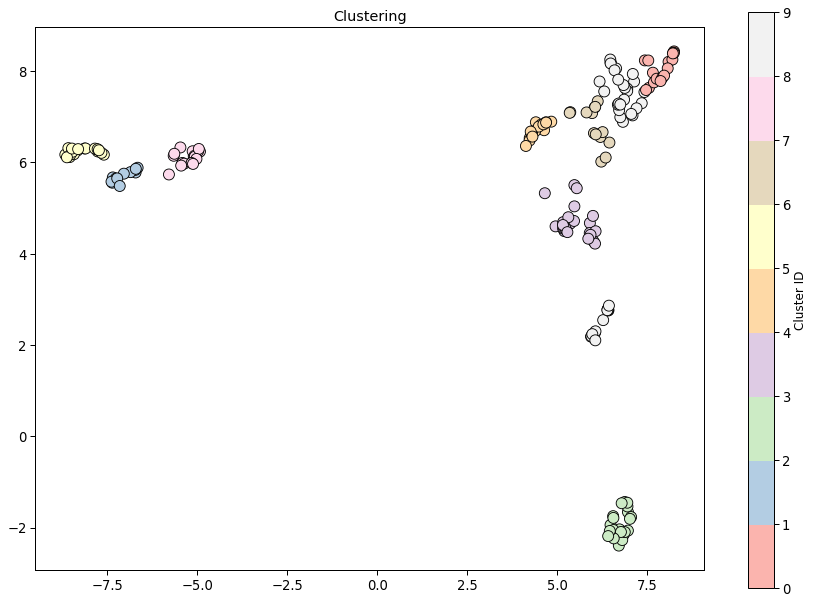

In [28]:
fig,ax = plt.subplots(1,1,figsize=(12,10))

pal = 'Pastel1'

cmap =  mpl.cm.Pastel1#(mpl.colors.ListedColormap('viridis'))

#cmap = (mpl.colors.ListedColormap(['goldenrod', 'green', 'blue','magenta']))

# define the bins and normalize
bounds = np.unique(kmeans_labels)
print(bounds)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

sns.scatterplot(*embeddings_scaffolds.T,s=120,c=kmeans_labels,ax=ax,cmap=cmap,edgecolor='k',norm=norm)

# create a second axes for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds)

ax.set_title('Clustering')
ax2.set_ylabel('Cluster ID', size=12)


In [29]:
np.unique(kmeans_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [30]:
scaffold_cluster = list(np.array(hier3)[np.where(kmeans_labels==9)])

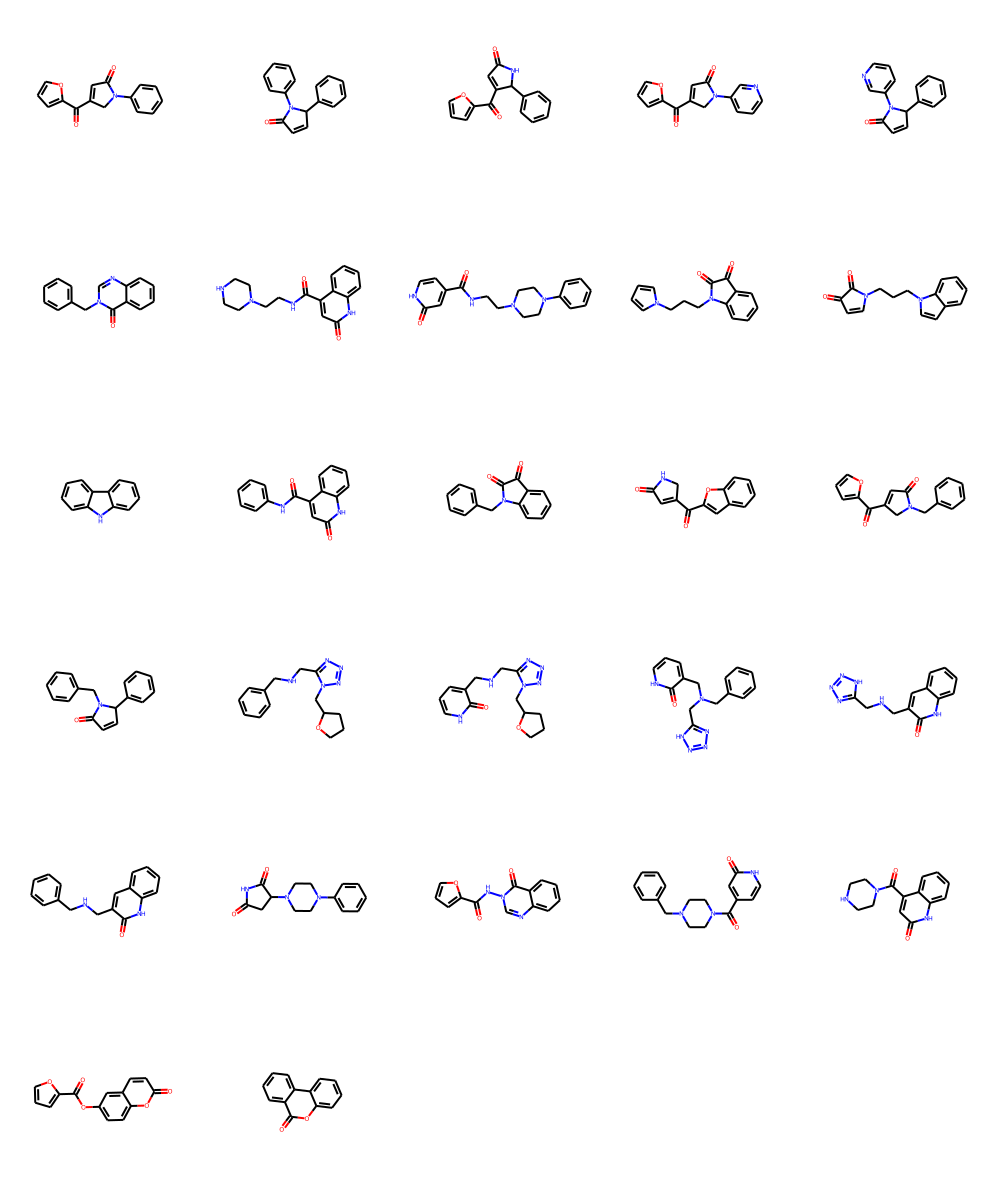

In [31]:
Draw.MolsToGridImage(list(map(Chem.MolFromSmiles,scaffold_cluster)),molsPerRow=5)

## HDBSCAN

In [32]:
labels = hdbscan.HDBSCAN(
    min_samples=5,
    min_cluster_size=5,
).fit_predict(embeddings_scaffolds)

In [33]:
clustered = (labels>=0)
clustered

array([False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,

In [44]:
len(cmaplist)

11

[ 0  1  2  3  4  5  6  7  8  9 10]


/home/marcossantana/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Cluster ID')

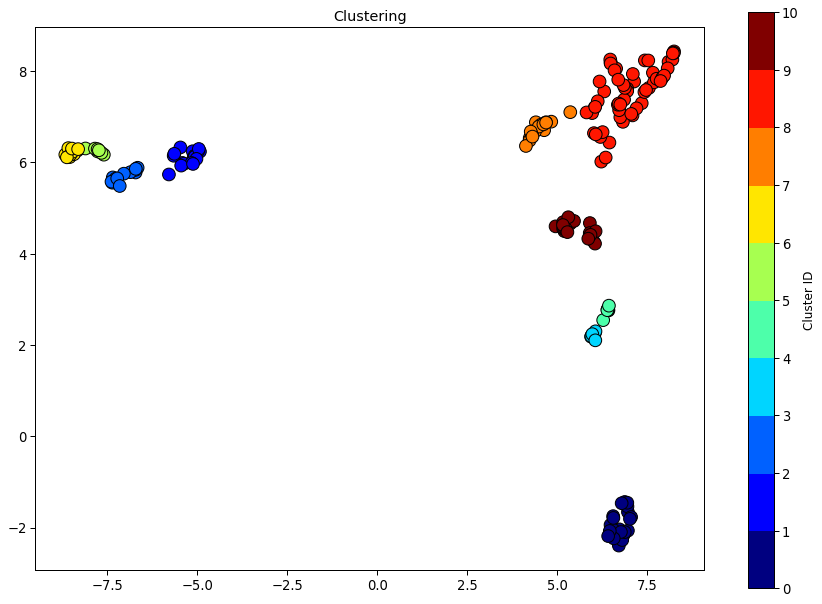

In [59]:
fig,ax = plt.subplots(1,1,figsize=(12,10))

pal = 'Pastel1'

cmap =  mpl.cm.jet#(mpl.colors.ListedColormap('viridis'))

# # extract all colors from the .jet map
# cmaplist = [cmap(i) for i in range(cmap.N)]
# # force the first color entry to be grey
# cmaplist.append((.5, .5, .5, 1.0))
# cmaplist.append((.5, .5, .8, 1.0))
# #cmap = (mpl.colors.ListedColormap(['goldenrod', 'green', 'blue']))

# # create the new map
# cmap = mpl.colors.LinearSegmentedColormap.from_list(
#     'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.unique(labels[clustered])
print(bounds)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

sns.scatterplot(embeddings_scaffolds[clustered, 0], embeddings_scaffolds[clustered, 1],s=160,c=labels[clustered],ax=ax,cmap=cmap,edgecolor='k',norm=norm)

# create a second axes for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
    spacing='proportional', ticks=bounds)

ax.set_title('Clustering')
ax2.set_ylabel('Cluster ID', size=12)


In [47]:
np.unique(labels[clustered])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

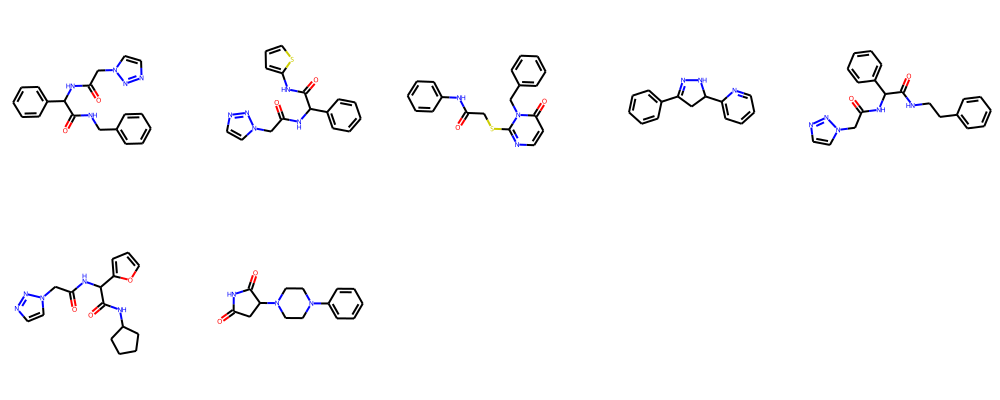

In [58]:
scaffold_cluster = list(np.array(hier3)[np.where(labels[clustered]==9)])
Draw.MolsToGridImage(list(map(Chem.MolFromSmiles,scaffold_cluster)),molsPerRow=5)